In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/home/fractaluser/Downloads/driver_n_rollout')
pd.set_option('display.max_columns', None)
sns.set(font_scale = 1, style = 'whitegrid')
from sklearn.metrics import mean_squared_error
import random, time
from pandas import Interval
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import xgboost as xgb

/home/fractaluser/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('adult.csv')

In [3]:
data.head()

,age,workclass,education,marital_status,employment,relationship,race,gender,workhours,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,<=50K


In [4]:
data = data.drop(labels = ['employment', 'relationship'], axis = 1)

data = data[(data.education != ' 11th') & (data.education != ' Assoc-voc') & (data.education != ' Assoc-acdm')
           & (data.education != ' 7th-8th') & (data.education != ' Prof-school') & (data.education != ' 9th') 
           & (data.education != ' 5th-6th') & (data.education != ' 1st-4th') & (data.education != ' Preschool') 
           & (data.marital_status != ' Married-AF-spouse') & (data.workclass != ' ?') 
           & (data.workclass != ' Self-emp-not-inc') & (data.workclass != ' Self-emp-inc')].reset_index(drop = True)

In [5]:
numerical_data = data.copy()

lbl1 = LabelEncoder()
numerical_data.gender = lbl1.fit_transform(numerical_data.gender)

lbl2 = LabelEncoder()
numerical_data.income = lbl2.fit_transform(numerical_data.income)

lbl3 = LabelEncoder()
numerical_data.marital_status = lbl3.fit_transform(numerical_data.marital_status)

lbl4 = LabelEncoder()
numerical_data.race = lbl4.fit_transform(numerical_data.race)

lbl5 = LabelEncoder()
numerical_data.workclass = lbl5.fit_transform(numerical_data.workclass)

In [6]:
numerical_data.head()

,age,workclass,education,marital_status,race,gender,workhours,income
0,39,4,Bachelors,3,4,1,40,0
1,38,3,HS-grad,0,4,1,40,0
2,28,3,Bachelors,1,2,0,40,0
3,37,3,Masters,1,4,0,40,0
4,31,3,Masters,3,4,0,50,1


In [7]:
numerical_data['age_group'] = pd.DataFrame({'age_group':pd.cut(numerical_data.age, 6)})
numerical_data['workhours_group'] = pd.DataFrame({'workhours_group':pd.cut(numerical_data.workhours, 6)})

numerical_data.education.replace([' 10th', ' 12th', ' HS-grad', ' Some-college', 
                                 ' Bachelors', ' Masters', ' Doctorate'], [1, 2, 3, 4, 5, 6, 7], inplace = True)
numerical_data.workhours_group.replace([Interval(0.902, 17.333, closed = 'right'), Interval(17.333, 33.667, closed='right')
                                  , Interval(33.667, 50.0, closed = 'right'), Interval(50.0, 66.333, closed = 'right'), 
                                 Interval(66.333, 82.667, closed = 'right'), Interval(82.667, 99.0, closed = 'right')]
                                 , [1, 2, 3, 4, 5, 6], inplace = True)
numerical_data.age_group.replace([Interval(16.927, 29.167, closed = 'right'), Interval(29.167, 41.333, closed='right')
                                  , Interval(41.333, 53.5, closed = 'right'), Interval(53.5, 65.667, closed = 'right'), 
                                 Interval(65.667, 77.833, closed = 'right'), Interval(77.833, 90.0, closed = 'right')]
                                 , [1, 2, 3, 4, 5, 6], inplace = True)

In [8]:
kmeans = KMeans(n_clusters = 6, random_state = 1)
clustering_model = kmeans.fit(numerical_data.drop(labels = ['age', 'workhours'], axis = 1))

In [9]:
numerical_data['cluster'] = pd.DataFrame({'cluster':clustering_model.labels_})

In [10]:
lift = []
for i in range(len(numerical_data)):
    if numerical_data.cluster[i] == 0:
        lift.append(np.round(random.uniform(-.8, -.5), 2))
    elif numerical_data.cluster[i] == 1:
        lift.append(np.round(random.uniform(-.5, -.2), 2))
    elif numerical_data.cluster[i] == 2:
        lift.append(0)
    elif numerical_data.cluster[i] == 3:
        lift.append(np.round(random.uniform(.1, .4),2))
    elif numerical_data.cluster[i] == 4:
        lift.append(np.round(random.uniform(.4, .7),2))
    else:
        lift.append(np.round(random.uniform(.7, 1.2),2))

In [11]:
numerical_data['lift'] = pd.DataFrame({'lift':lift})

change = numerical_data.sample(2000).index
numerical_data.loc[change,'lift'] = float(0)

In [12]:
training = numerical_data.drop(labels = ['lift', 'workhours', 'age', 'cluster'], axis = 1)
target = numerical_data['lift']

In [13]:
xdata, xtest, ydata, ytest = train_test_split(training, target, test_size = 0.25, random_state = 1)
xdata = xdata.reset_index(drop = True)
xtest = xtest.reset_index(drop = True)
ydata = ydata.reset_index(drop = True)
ytest = ytest.reset_index(drop = True)

In [14]:
xtrain, xval, ytrain, yval = train_test_split(xdata, ydata, test_size = 0.25, random_state = 1)
xtrain = xtrain.reset_index(drop = True)
xval = xval.reset_index(drop = True)
ytrain = ytrain.reset_index(drop = True)
yval = yval.reset_index(drop = True)

In [15]:
trial1 = time.time()
linear_model = LassoCV(eps=0.001, n_alphas=100, fit_intercept=True, precompute='auto', max_iter=1000 ,cv=2, n_jobs=-1, random_state=1, selection='cyclic')
regress = linear_model.fit(xdata, ydata)
print('Processing time =', time.time()-trial1, 'seconds')
lasso_performance = regress.predict(xtest)

Processing time = 0.3141343593597412 seconds


In [16]:
print('Error after lasso =', (mean_squared_error(ytest, lasso_performance))**0.5)

Error after lasso = 0.40929309524263024


In [17]:
print('Lasso reg. coefficients ->',regress.coef_)

Lasso reg. coefficients -> [-0.15589634 -0.12225956  0.07285923  0.13497024 -0.00891521 -0.15692454
 -0.16878794 -0.04355896]


In [18]:
trial2 = time.time()
params = {"objective":"reg:linear",
          "booster":"gbtree",
          "eta":0.1,
          "max_depth": 3,
         "subsample":0.75,
         "silent":0,
         "seed":1,
         "lambda":.25,
         "alpha":.1}

num_boost_round = 1000

dtrain = xgb.DMatrix(xtrain, ytrain)
dvalid = xgb.DMatrix(xval, yval)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

booster = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = 25, verbose_eval=10)
print('Processing time =', time.time()-trial2, 'seconds')
performance = booster.predict(xgb.DMatrix(xtest))

[0]	train-rmse:0.538713	eval-rmse:0.53662
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 25 rounds.
[10]	train-rmse:0.305603	eval-rmse:0.303289
[20]	train-rmse:0.252905	eval-rmse:0.249963
[30]	train-rmse:0.238909	eval-rmse:0.235835
[40]	train-rmse:0.233503	eval-rmse:0.230428
[50]	train-rmse:0.230698	eval-rmse:0.227662
[60]	train-rmse:0.228954	eval-rmse:0.226118
[70]	train-rmse:0.227376	eval-rmse:0.2242
[80]	train-rmse:0.226643	eval-rmse:0.223562
[90]	train-rmse:0.225788	eval-rmse:0.222678
[100]	train-rmse:0.224973	eval-rmse:0.221818
[110]	train-rmse:0.224159	eval-rmse:0.220885
[120]	train-rmse:0.223478	eval-rmse:0.220421
[130]	train-rmse:0.222427	eval-rmse:0.219331
[140]	train-rmse:0.221705	eval-rmse:0.218759
[150]	train-rmse:0.221217	eval-rmse:0.218372
[160]	train-rmse:0.220706	eval-rmse:0.217921
[170]	train-rmse:0.220242	eval-rmse:0.21741
[180]	train-rmse:0.21988	eval-rmse:0.217111
[190]	train-rmse:0

In [19]:
print('Error on test set =', mean_squared_error(ytest, performance)**.5)

Error on test set = 0.21267701712922954


In [20]:
test_pool = xdata.join(ydata)
target_pool = xtest.join(pd.DataFrame(booster.predict(xgb.DMatrix(xtest)))).rename(columns = {0:'lift'})

In [21]:
kmeans_specific = KMeans(n_clusters = 6, random_state = 1)
clustering_specific = kmeans_specific.fit(test_pool)
test_labels = clustering_specific.labels_
target_labels = clustering_specific.predict(target_pool)
test_pool['cluster'] = pd.DataFrame({'cluster':test_labels})
target_pool['cluster'] = pd.DataFrame({'cluster':target_labels})

In [22]:
test_pool.education.replace( [1, 2, 3, 4, 5, 6, 7],[' 10th', ' 12th', ' HS-grad', ' Some-college', 
                                 ' Bachelors', ' Masters', ' Doctorate'], inplace = True)
test_pool.workhours_group.replace( [1, 2, 3, 4, 5, 6],[Interval(0.902, 17.333, closed = 'right'), Interval(17.333, 33.667, closed='right')
                                  , Interval(33.667, 50.0, closed = 'right'), Interval(50.0, 66.333, closed = 'right'), 
                                 Interval(66.333, 82.667, closed = 'right'), Interval(82.667, 99.0, closed = 'right')]
                                 , inplace = True)
test_pool.age_group.replace([1, 2, 3, 4, 5, 6],[Interval(16.927, 29.167, closed = 'right'), Interval(29.167, 41.333, closed='right')
                                  , Interval(41.333, 53.5, closed = 'right'), Interval(53.5, 65.667, closed = 'right'), 
                                 Interval(65.667, 77.833, closed = 'right'), Interval(77.833, 90.0, closed = 'right')]
                                 ,  inplace = True)

target_pool.education.replace( [1, 2, 3, 4, 5, 6, 7],[' 10th', ' 12th', ' HS-grad', ' Some-college', 
                                 ' Bachelors', ' Masters', ' Doctorate'], inplace = True)
target_pool.workhours_group.replace( [1, 2, 3, 4, 5, 6],[Interval(0.902, 17.333, closed = 'right'), Interval(17.333, 33.667, closed='right')
                                  , Interval(33.667, 50.0, closed = 'right'), Interval(50.0, 66.333, closed = 'right'), 
                                 Interval(66.333, 82.667, closed = 'right'), Interval(82.667, 99.0, closed = 'right')]
                                 , inplace = True)
target_pool.age_group.replace([1, 2, 3, 4, 5, 6],[Interval(16.927, 29.167, closed = 'right'), Interval(29.167, 41.333, closed='right')
                                  , Interval(41.333, 53.5, closed = 'right'), Interval(53.5, 65.667, closed = 'right'), 
                                 Interval(65.667, 77.833, closed = 'right'), Interval(77.833, 90.0, closed = 'right')]
                                 ,  inplace = True)

In [23]:
test_pool.gender = lbl1.inverse_transform(test_pool.gender)
test_pool.income = lbl2.inverse_transform(test_pool.income)
test_pool.marital_status = lbl3.inverse_transform(test_pool.marital_status)
test_pool.race = lbl4.inverse_transform(test_pool.race)
test_pool.workclass = lbl5.inverse_transform(test_pool.workclass)

target_pool.gender = lbl1.inverse_transform(target_pool.gender)
target_pool.income = lbl2.inverse_transform(target_pool.income)
target_pool.marital_status = lbl3.inverse_transform(target_pool.marital_status)
target_pool.race = lbl4.inverse_transform(target_pool.race)
target_pool.workclass = lbl5.inverse_transform(target_pool.workclass)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/fractaluser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/fractaluser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/fractaluser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of

In [24]:
mean_lift = []
for i in test_pool.cluster.unique():
    mean_lift.append({"avg_lift":np.mean(test_pool[(test_pool.cluster == i)].lift), "cluster":i})
mean_lift = pd.DataFrame(mean_lift)

prime_driver_cluster = mean_lift.cluster[mean_lift.avg_lift.argmax()]
prime_drainer_cluster = mean_lift.cluster[mean_lift.avg_lift.argmin()]

/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  
/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  import sys


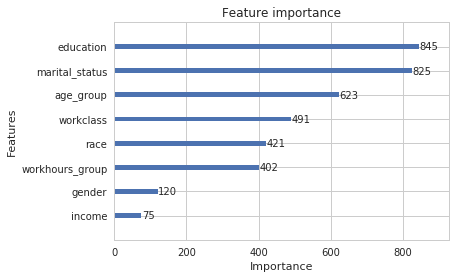

In [25]:
xgb.plot_importance(booster, xlabel='Importance', ylabel='Features')
plt.show()

In [26]:
prime_driven = test_pool[(test_pool.cluster == prime_driver_cluster)].reset_index(drop = True).drop(labels = ['cluster'], axis = 1)
prime_drained = test_pool[(test_pool.cluster == prime_drainer_cluster)].reset_index(drop = True).drop(labels = ['cluster'], axis = 1)

In [27]:
good_features_for_driven = []
overlapping_features_for_driven = []
bad_features_for_driven = []

for i in prime_driven.columns:
    if (prime_driven[i].value_counts()/len(prime_driven)).values[0] >= 0.7:
        good_features_for_driven.append(i)
    elif (prime_driven.marital_status.value_counts()/len(prime_driven)).values[0] - (prime_driven.marital_status.value_counts()/len(prime_driven)).values[1] < 0.1 and (prime_driven.marital_status.value_counts()/len(prime_driven)).values[0] - (prime_driven.marital_status.value_counts()/len(prime_driven)).values[1] >= 0.7:
        overlapping_features_for_driven.append(i)
    else:
        bad_features_for_driven.append(i)


In [28]:
good_features_for_drained = []
overlapping_features_for_drained = []
bad_features_for_drained = []

for i in prime_drained.columns:
    if (prime_drained[i].value_counts()/len(prime_drained)).values[0] >= 0.7:
        good_features_for_drained.append(i)
    elif (prime_drained.marital_status.value_counts()/len(prime_drained)).values[0] - (prime_drained.marital_status.value_counts()/len(prime_drained)).values[1] < 0.1 and (prime_drained.marital_status.value_counts()/len(prime_drained)).values[0] - (prime_drained.marital_status.value_counts()/len(prime_drained)).values[1] >= 0.7:
        overlapping_features_for_drained.append(i)
    else:
        bad_features_for_drained.append(i)


In [29]:
prime_driver_group = []
prime_drive = mean_lift.avg_lift.max()
for i in good_features_for_driven:
    prime_driver_group.append(prime_driven[i].value_counts().index[0])
for j in overlapping_features_for_driven:
    prime_driver.append([prime_driven[i].value_counts().index[0], prime_driven[i].value_counts().index[1]])

In [30]:
print('Combination of features driving the lift the most are ->', prime_driver_group)
print('Drive =', prime_drive)

Combination of features driving the lift the most are -> [' Private', ' Never-married', ' White', ' <=50K', Interval(16.927, 29.167, closed='right')]
Drive = 0.8612662483191393


In [31]:
prime_drainer_group = []
prime_drain = mean_lift.avg_lift.min()
for i in good_features_for_drained:
    prime_drainer_group.append(prime_drained[i].value_counts().index[0])
for j in overlapping_features_for_drained:
    prime_drained.append([prime_drained[i].value_counts().index[0], prime_drained[i].value_counts().index[1]])

In [32]:
print('Combination of features draining the lift the most are ->', prime_drainer_group)
print('Drain =', prime_drain)

Combination of features draining the lift the most are -> [' Private', ' Married-civ-spouse', ' White', ' Male', Interval(33.667, 50.0, closed='right')]
Drain = -0.59654912836767


In [33]:
good_features_for_driven

['workclass', 'marital_status', 'race', 'income', 'age_group']

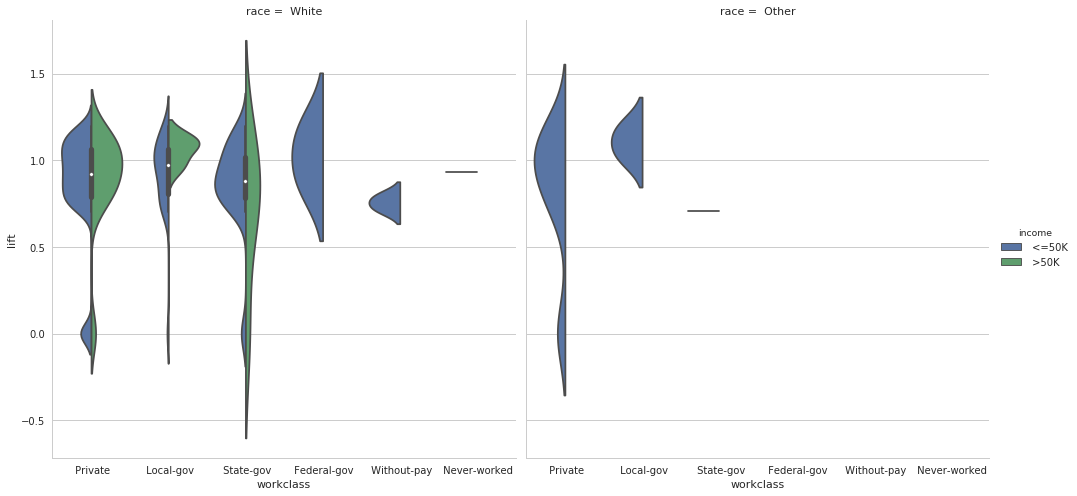

In [34]:
sns.factorplot(x="workclass", y="lift", hue="income",
               col="race", data=prime_driven, kind="violin", size = 7, aspect=1, split = True)
plt.show()

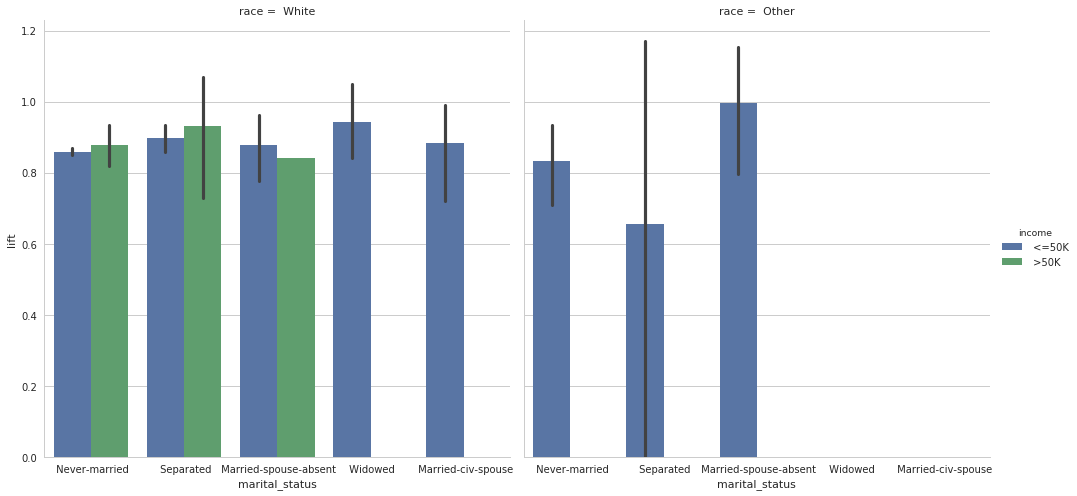

In [35]:
sns.factorplot(x="marital_status", y="lift", hue="income",
               col="race", data=prime_driven, kind="bar", size = 7, aspect=1)
plt.show()

In [36]:
good_features_for_drained

['workclass', 'marital_status', 'race', 'gender', 'workhours_group']

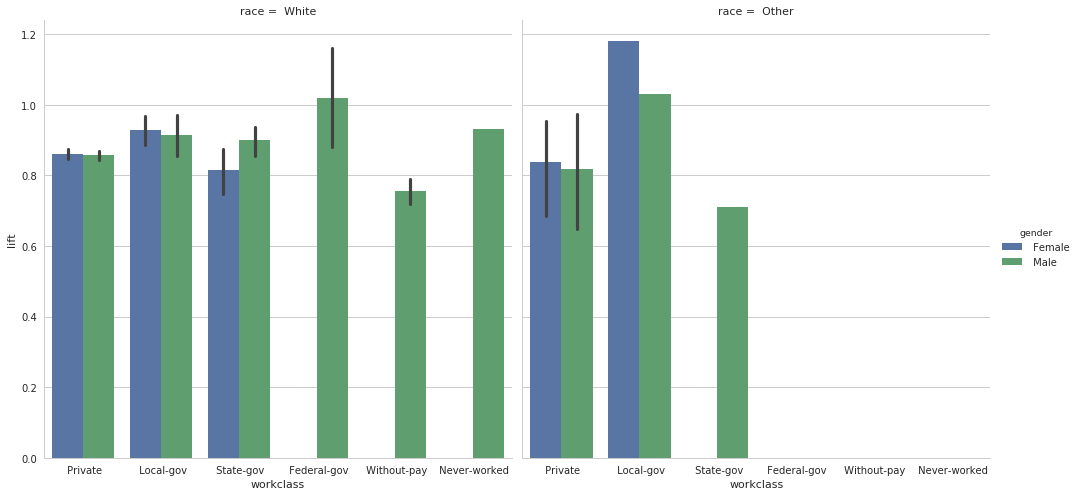

In [37]:
sns.factorplot(x="workclass", y="lift", hue="gender",
               col="race", data=prime_driven, kind="bar", size = 7, aspect=1)
plt.show()

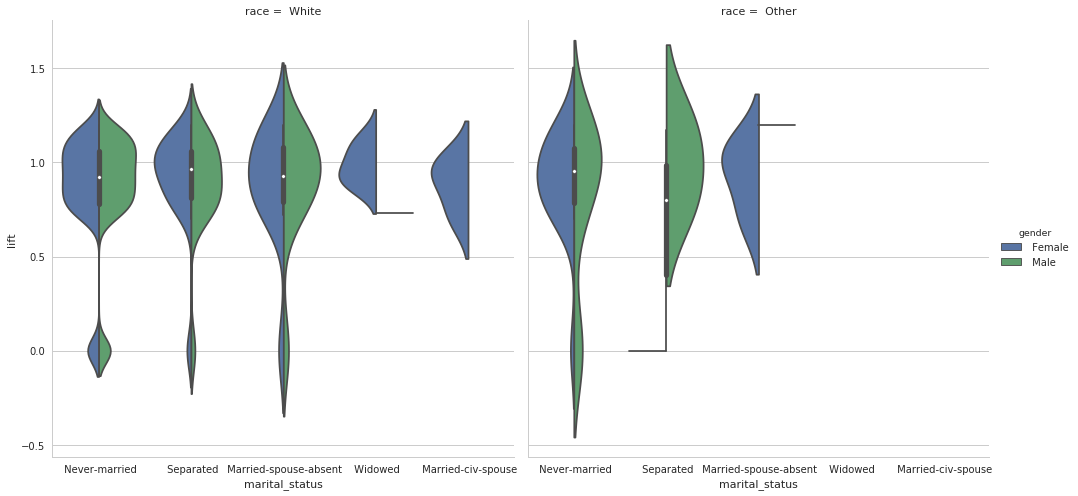

In [38]:
sns.factorplot(x="marital_status", y="lift", hue="gender",
               col="race", data=prime_driven, kind="violin", size = 7, aspect=1, split = True)
plt.show()

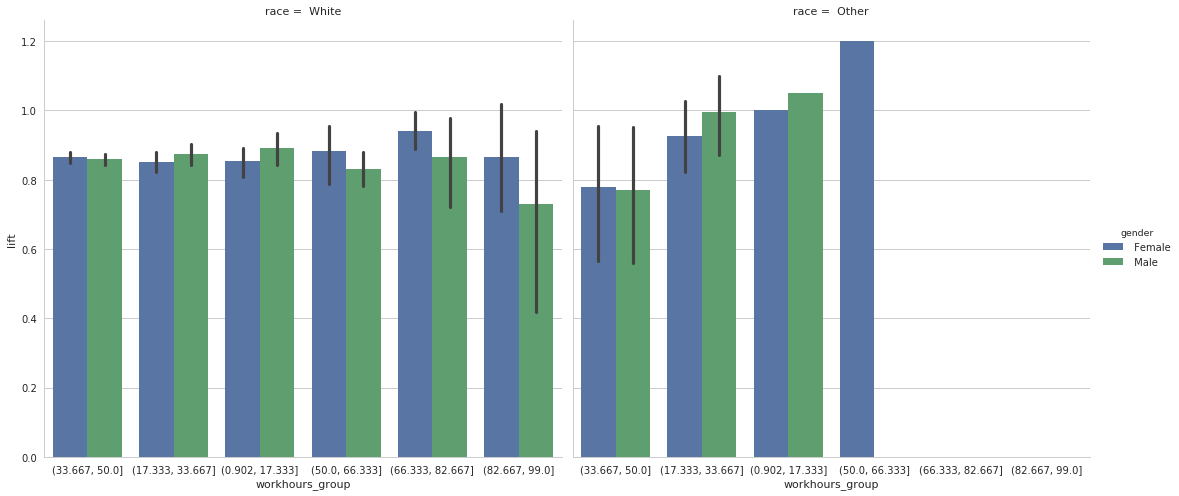

In [39]:
sns.factorplot(x="workhours_group", y="lift", hue="gender",
               col="race", data=prime_driven, kind="bar", size = 7, aspect=1.1)
plt.show()

In [40]:
order_of_rolling_out = target_pool.copy()
order_of_rolling_out = order_of_rolling_out.sort_values(by='lift', ascending = False).reset_index(drop = True)

In [41]:
order_of_rolling_out.head()

,workclass,education,marital_status,race,gender,income,age_group,workhours_group,lift,cluster
0,Private,Masters,Separated,White,Female,<=50K,"(16.927, 29.167]","(33.667, 50.0]",1.133988,5
1,State-gov,Masters,Never-married,White,Male,<=50K,"(16.927, 29.167]","(0.902, 17.333]",1.031284,5
2,Never-worked,Some-college,Never-married,White,Male,<=50K,"(16.927, 29.167]","(0.902, 17.333]",0.994170,5
3,State-gov,Some-college,Separated,White,Male,<=50K,"(16.927, 29.167]","(33.667, 50.0]",0.984605,5
4,Private,Some-college,Separated,White,Male,<=50K,"(16.927, 29.167]","(50.0, 66.333]",0.977585,5
